# Coordinate transformation of BoundingBox

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=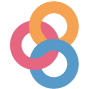)](https://)

---

This is a quick guide to converting BoundingBox loaded on SoccerTrack to the pitch coordinate.

In [1]:
%load_ext autoreload
%autoreload 2

### 1. Load video and BoundingBox

In [2]:
import soccertrack
from soccertrack import Camera
from soccertrack import load_df
from soccertrack.logger import show_df

dataset_path = soccertrack.datasets.get_path("wide_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

cam = Camera(path_to_mp4)  # Camera object will be used to load frames
bbdf = soccertrack.load_df(path_to_csv)  # We will use this as ground truth
show_df(bbdf.head())

Now let's visualize the loaded frames

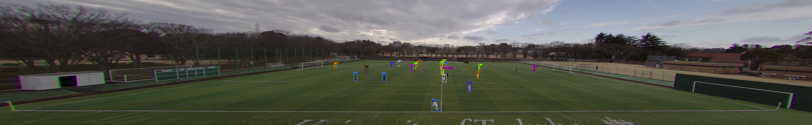

In [3]:
from soccertrack.utils import cv2pil

frame = cam.get_frame(1)
vis_frame = bbdf.visualize_frame(1, frame)

cv2pil(vis_frame, convert_bgr2rgb=False).resize((vis_frame.shape[1] // 8, vis_frame.shape[0] // 8))

### 2. Convert BoundingBox coordinates to pitch coordinates
First, load the match video and the corresponding pitch keypoints, and then compute the projection matrix.

In [4]:
import numpy as np
from ast import literal_eval
import json 
from soccertrack.utils import get_git_root

def load_keypoints(keypoint_json):
    with open(keypoint_json, 'r') as f:
        data = json.load(f)

    source_keypoints = []
    target_keypoints = []

    for key,value in data.items():
        source_kp = value
        target_kp = literal_eval(key)
        source_keypoints.append(source_kp)
        target_keypoints.append(target_kp)

    source_keypoints = np.array(source_keypoints)
    target_keypoints = np.array(target_keypoints)
    return source_keypoints, target_keypoints

keypoint_json = get_git_root() / 'notebooks/02_user_guide/assets/soccer_keypoints.json'
cam.source_keypoints, cam.target_keypoints = load_keypoints(keypoint_json)
print(cam.H)

[[  -0.022512    -0.15867      143.47]
 [  0.0039563    -0.25595      113.53]
 [ 5.8605e-05  -0.0030103           1]]


Based on the calculated projection matrix, the Bounding Box is projected onto the pitch coordinate.  

The `method` argument can be used to the point within the bounding box to transform. \
Options include `center`, `bottom_middle`, `top_middle`.

In [5]:
codf = bbdf.to_codf(cam.H, method='bottom_middle')
show_df(codf.head())

Finally, visualize the codf to verify that the BoundingBox is correctly projected

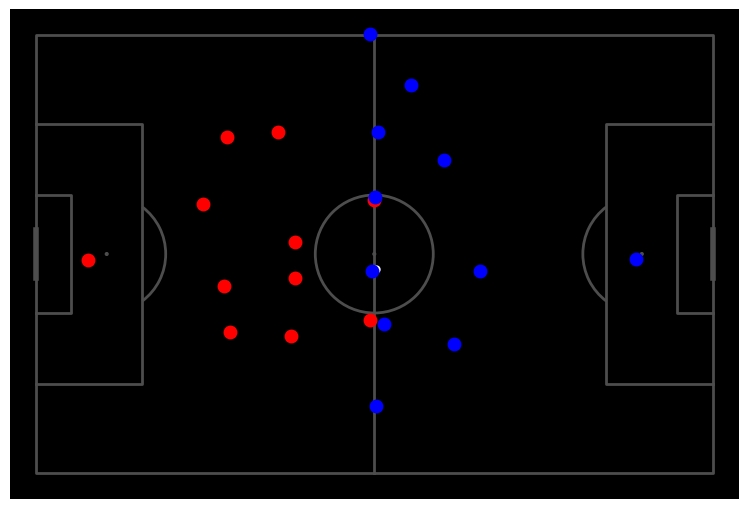

In [6]:
vis_codf = codf.visualize_frame(1, home_key='0', away_key='1', ball_key='BALL')